# Import statements

In [22]:
import os
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt

2.18.0


# Model

First we load MobileNet model

In [38]:
selected_classes = ['231-n000081-silky_terrier', '340-n000120-Yorkshire_terrier', '202-n000020-Australian_terrier', '203-n000016-Norwich_terrier','211-n000009-cairn', '203-n000021-Tibetan_terrier', '215-n000038-Lhasa', '211-n000052-Dandie_Dinmont', ]                    

In [39]:
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))
#conv_base.summary()

Add new top layers (decoder)

In [40]:
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras import layers, Model

# Define data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(0.1)  # Low contrast adjustment
])

# Load the MobileNet model without the top layers
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

# Define the augmented input by applying data augmentation to the input layer
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = data_augmentation(x)  # Apply augmentation here
x = conv_base(x)  # Pass augmented data through the MobileNet base

# Add custom top layers
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(1024, activation='relu')(x)  # Dense layer
#x = Dense(1024, activation='relu', 
#                 kernel_regularizer=regularizers.l2(0.01))(x)  # Dense layer with L2
#x = layers.Dropout(0.5)(x)  # Optional dropout
preds = Dense(len(selected_classes), activation='softmax')(x)  # Final output layer

# Create the final model
model = Model(inputs=inputs, outputs=preds)
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_5 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_5 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,286,664 (16.35 MB)

 Trainable params: 4,264,776 (16.27 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [41]:
for layer in model.layers[:3]:
    print("off: ", layer)
    layer.trainable=False
for layer in model.layers[3:]:
    print("on: ", layer)
    layer.trainable=True
    

off:  <InputLayer name=input_layer_15, built=True>
off:  <Sequential name=sequential_3, built=True>
off:  <Functional name=mobilenet_1.00_224, built=True>
on:  <GlobalAveragePooling2D name=global_average_pooling2d_5, built=True>
on:  <Dense name=dense_10, built=True>
on:  <Dense name=dense_11, built=True>


Define the training set and dataset. Both are of type `Dataloader`

In [42]:
dog_class_directory = os.getcwd()+'/dog_classes'

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=32,
    subset = "training",
    validation_split =0.2,
    shuffle=True,
    seed=123
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=32,
    subset = "validation",
    validation_split =0.2,
    shuffle=True,
    seed=123
)


Found 1816 files belonging to 8 classes.
Using 1453 files for training.
Found 1816 files belonging to 8 classes.
Using 363 files for validation.


Define the optimizer and train the model

In [43]:
sgd_optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history = model.fit(train_dataset, 
          validation_data=val_dataset, 
          epochs=50)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 302ms/step - accuracy: 0.2209 - loss: 2.0661 - val_accuracy: 0.5096 - val_loss: 1.3840
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 290ms/step - accuracy: 0.5866 - loss: 1.2272 - val_accuracy: 0.6942 - val_loss: 1.0025
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 289ms/step - accuracy: 0.6992 - loss: 0.9577 - val_accuracy: 0.7190 - val_loss: 0.8715
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 290ms/step - accuracy: 0.7468 - loss: 0.8082 - val_accuracy: 0.7355 - val_loss: 0.8327
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 294ms/step - accuracy: 0.7725 - loss: 0.7455 - val_accuracy: 0.7576 - val_loss: 0.7543
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 303ms/step - accuracy: 0.8020 - loss: 0.6758 - val_accuracy: 0.7631 - val_loss: 0.7343
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 295ms/step - accuracy: 0.8163 - loss: 0.6227 - val_accuracy: 0.7796 - val_loss: 0.6836
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 290ms/step - accuracy: 0.8407 - loss: 0.5549 - val_accu

Plot `accuracy` against `epochs`.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


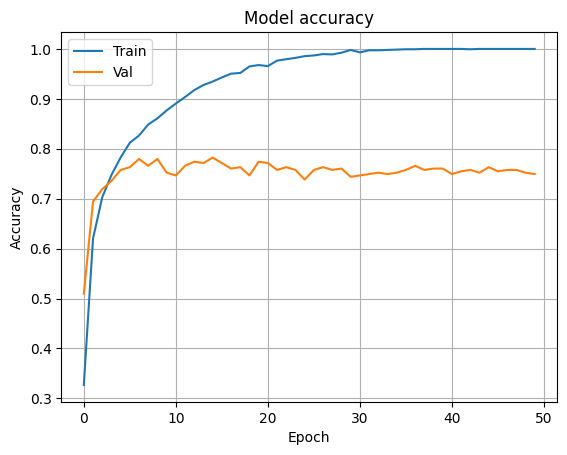

In [44]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()

plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Plot `loss` against `epochs`

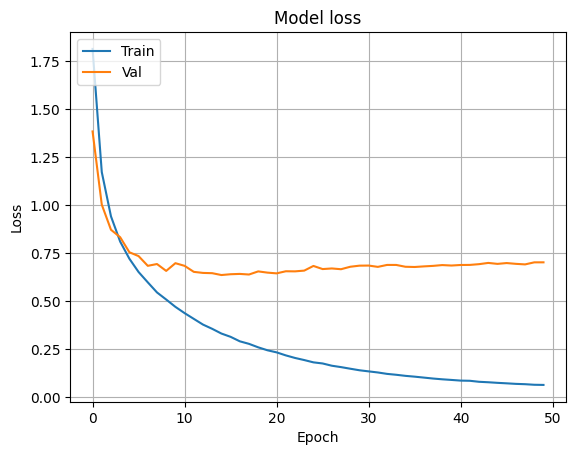

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()